### 지금까지 했던 것 총정리

In [123]:
### 라이브러리
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

from xgboost import XGBRegressor
from xgboost import XGBClassifier

import statsmodels.api as sm

import datetime


### 환경설정
np.random.seed(4)


### 함수 정의
def preprocess_transaction_flag(df):
    df['transaction_flag'] = df['transaction_count'].apply(lambda x: 1 if x > 0 else 0)
    return df

def calculate_mdd(cumulative_returns):
    """
    Maximum Drawdown (MDD) 계산 함수
    :param cumulative_returns: 누적 수익률 (1 + 전략 수익률).cumprod() 형태의 데이터
    :return: MDD (최대 낙폭)
    """
    peak = np.maximum.accumulate(cumulative_returns)  # 최고점 누적 기록
    drawdown = (cumulative_returns - peak) / peak  # 각 시점의 손실 비율
    mdd = drawdown.min()  # 최대 손실율 (음수 값)
    return mdd


def trim_date(df, start, end):
    ### df date 형식 맞춰주기
    df['date'] = df['date'].astype(str)
    if len(df['date'][0]) == 8:
        df['date'] = df['date'].apply(lambda x: x[0:4]+'-'+x[4:6]+'-'+x[6:])


    return df[(df['date']>=start) & (df['date']<=end)]

### 데이터 세팅

In [124]:
### 학습용 데이터 읽기
test_df = pd.read_csv("data/test/test_df.csv")

### target df 읽기
columns = ['date', 'transaction_count', 'transaction_amount', 'transaction_flag']

# target_event_receive_df = pd.read_csv("./data/target/event_2_day_transactions_over_100_receive.csv")
target_event_receive_df = pd.read_csv("./data/target/event_2_day_transactions_over_100_threshold_500_receive.csv")
# target_event_receive_df = pd.read_csv("./data/target/event_1_day_transactions_over_100_receive.csv")
# target_event_receive_df = pd.read_csv("./data/target/event_2_day_transactions_over_136_threshold_1000_receive.csv")
# target_event_receive_df = pd.read_csv("./data/target/wallet_ranking_target_unnamed_250110.csv")
target_event_send_df = pd.read_csv("./data/target/event_2_day_transactions_over_100_send.csv")

target_event_receive_df = preprocess_transaction_flag(target_event_receive_df)
target_event_send_df = preprocess_transaction_flag(target_event_send_df)

target_event_receive_df.columns = columns
target_event_send_df.columns = columns

### target difference df
target_event_difference_df = target_event_receive_df.copy()
target_event_difference_df['transaction_count'] = (target_event_receive_df['transaction_count'] - target_event_send_df['transaction_count'])
target_event_difference_df['transaction_amount'] = (target_event_receive_df['transaction_amount'] - target_event_send_df['transaction_amount'])
target_event_difference_df['transaction_flag'] = target_event_difference_df['transaction_amount'].apply(
    lambda x: 1 if x > 0 else (0 if x == 0 else -1)
)

### 날짜에 맞춰 자르기
start = (test_df['date'].values)[0]
end = (test_df['date'].values)[-1]

target_event_receive_df = trim_date(target_event_receive_df, start, end)
target_event_send_df = trim_date(target_event_send_df, start, end)
target_event_difference_df = trim_date(target_event_difference_df, start, end)

test_df.set_index('date', inplace=True)

### Bitcoin Event Flag 추가
event_df = pd.read_csv("data/event/bitcoin_event.csv").set_index("Date")
test_df['event_flag'] = event_df
test_df['lag_event_flag'] = test_df['event_flag'].shift(-2).fillna(0)

### 분석 데이터 선택
target_df = target_event_receive_df.copy().set_index('date')

### test_df에 target_df 데이터 적용
test_df['transaction_count'] = target_df['transaction_count']
test_df['transaction_amount'] = target_df['transaction_amount']
test_df['transaction_flag'] = target_df['transaction_flag']
test_df['transaction_amount_usd'] = test_df['transaction_amount'] * test_df['close']

### test_df의 target 선택
test_df['target'] = test_df['transaction_amount_usd']

### target 관련 파생변수 생성
test_df['target_delta'] = test_df['target'].diff(1)
test_df['target_returns'] = test_df['target'].pct_change(1)

### 회귀분석 돌릴때 Cheating 방지용으로 transaction 관련 target값 삭제
transaction_count = test_df['transaction_count'].copy()
transaction_amount = test_df['transaction_amount'].copy()
transaction_amount_usd = test_df['transaction_amount_usd'].copy()
returns_copy = test_df['returns'].copy()
test_df = test_df.drop(['transaction_count', 'transaction_amount', 'transaction_flag', 'transaction_amount_usd'], axis=1)

##### 전처리 관련
### 변화율에서 inf값 나올텐데 그거 어떻게 처리할지
test_df = test_df.replace([np.inf, -np.inf], np.nan)

### NaN값 처리 방법
test_df = test_df.fillna(test_df.mean())

### 스케일링
scaler = MinMaxScaler()
test_df = pd.DataFrame(scaler.fit_transform(test_df), columns=test_df.columns, index=test_df.index)

### 스케일링 유의 변수
test_df['returns'] = returns_copy

C:\Users\slaye\AppData\Local\Temp\ipykernel_28840\4029012319.py:57: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  test_df['target_returns'] = test_df['target'].pct_change(1)


### 기본적인 통계, 시계열 분석

In [125]:
test_df[['target', 'target_delta', 'target_returns']].describe()

,target,target_delta,target_returns
count,2830.000000,2830.000000,2830.000000
mean,0.033244,0.428244,0.003460
std,0.059974,0.039435,0.027496
min,0.000000,0.000000,0.000000
25%,0.010022,0.422463,0.000895
50%,0.021515,0.428244,0.001333
75%,0.035410,0.434007,0.002046
max,1.000000,1.000000,1.000000


In [126]:
np.corrcoef([transaction_amount, transaction_count])

array([[1.        , 0.80625767],
       [0.80625767, 1.        ]])

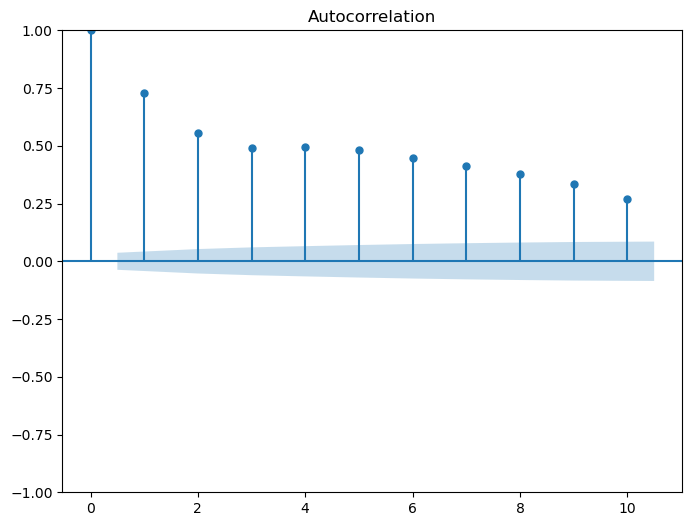

In [127]:
### target 값의 autocorrelation
sm.tsa.stattools.acf(test_df['target'], nlags=10, fft=False)

fig = plt.figure(figsize=(8,6))
fig.set_facecolor('white')
ax = fig.add_subplot()
sm.graphics.tsa.plot_acf(test_df['target'], lags=10, ax=ax)
plt.show()

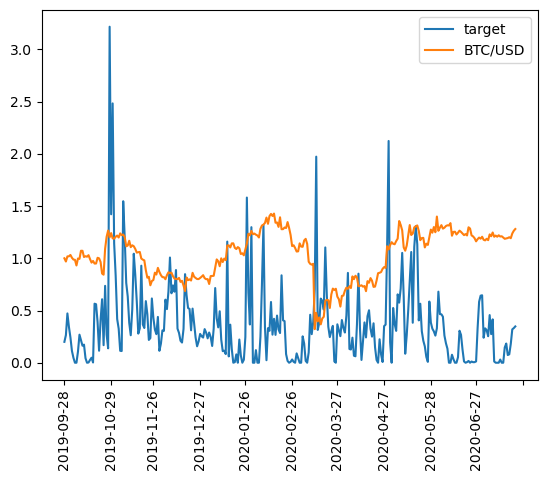

In [128]:
### target값과 가격 그래프
plot_df = test_df.iloc[1000:1300, :]
plt.plot(plot_df['target']/plot_df['target'].iloc[0]/5, label='target')
plt.plot(plot_df['close']/plot_df['close'].iloc[0], label='BTC/USD')
plt.xticks(rotation=90)
plt.legend()

ax = plt.gca()  # 현재 그래프의 X축 가져오기
ax.xaxis.set_major_locator(mdates.AutoDateLocator())  # 자동으로 적절한 간격 설정

plt.show()

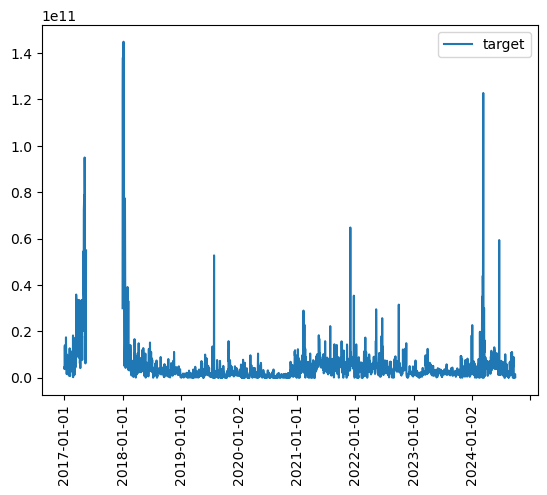

In [129]:
### target값과 가격 그래프
plt.plot(transaction_amount_usd, label='target')
plt.xticks(rotation=90)
plt.legend()

ax = plt.gca()  # 현재 그래프의 X축 가져오기
ax.xaxis.set_major_locator(mdates.AutoDateLocator())  # 자동으로 적절한 간격 설정

plt.show()

### Target의 Returns예측

In [130]:
# Independent, Dependent 분리
y = test_df['returns'].shift(-2).fillna(test_df['returns'].mean())
X = test_df[['target', 'volume']].fillna(test_df.mean())

# train, test 데이터 분리
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, shuffle=False)

X_with_const = sm.add_constant(X_test)

# OLS 회귀 적합
# ---------------------------------------------
lr = sm.OLS(y_test, X_with_const).fit()
print("=== OLS 기본 요약 ===")
print(lr.summary())

=== OLS 기본 요약 ===
                            OLS Regression Results                            
Dep. Variable:                returns   R-squared:                       0.012
Model:                            OLS   Adj. R-squared:                  0.009
Method:                 Least Squares   F-statistic:                     3.439
Date:                Tue, 25 Feb 2025   Prob (F-statistic):             0.0328
Time:                        15:03:05   Log-Likelihood:                 1289.2
No. Observations:                 566   AIC:                            -2572.
Df Residuals:                     563   BIC:                            -2559.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0016      0.001  

### Event Flag를 더미변수로 추가하면 기울기가 늘어나는지

In [131]:
# 파생변수 추가
test_df['event_target'] = test_df['target'] * test_df['event_flag']

# Independent, Dependent 분리
y = test_df['returns'].shift(-2).fillna(test_df['returns'].mean())
X = test_df[['target', 'volume', 'event_flag']].fillna(test_df.mean())

# train, test 데이터 분리
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, shuffle=False)

X_with_const = sm.add_constant(X_test)

# OLS 회귀 적합
# ---------------------------------------------
lr = sm.OLS(y_test, X_with_const).fit()
print("=== OLS 기본 요약 ===")
print(lr.summary())

=== OLS 기본 요약 ===
                            OLS Regression Results                            
Dep. Variable:                returns   R-squared:                       0.018
Model:                            OLS   Adj. R-squared:                  0.014
Method:                 Least Squares   F-statistic:                     4.286
Date:                Tue, 25 Feb 2025   Prob (F-statistic):            0.00521
Time:                        15:03:05   Log-Likelihood:                 1587.3
No. Observations:                 708   AIC:                            -3167.
Df Residuals:                     704   BIC:                            -3148.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0018      0.001  

### Target 값이 변동성을 유의미하게 설명하는지

In [132]:
test_df['volatility'] = test_df['returns']**2

# Independent, Dependent 분리
y = test_df['volatility'].shift(-2).fillna(test_df['volatility'].mean())
X = test_df[['target', 'volume', 'event_flag']].fillna(test_df.mean())

## train, test 데이터 분리
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, shuffle=False)

X_with_const = sm.add_constant(X_test)

# OLS 회귀 적합
# ---------------------------------------------
lr = sm.OLS(y_test, X_with_const).fit()
print("=== OLS 기본 요약 ===")
print(lr.summary())

=== OLS 기본 요약 ===
                            OLS Regression Results                            
Dep. Variable:             volatility   R-squared:                       0.065
Model:                            OLS   Adj. R-squared:                  0.061
Method:                 Least Squares   F-statistic:                     16.27
Date:                Tue, 25 Feb 2025   Prob (F-statistic):           3.10e-10
Time:                        15:03:05   Log-Likelihood:                 3560.5
No. Observations:                 708   AIC:                            -7113.
Df Residuals:                     704   BIC:                            -7095.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0004   8.25e-05  

### Target의 변화값이 Returns를 유의미하게 설명하는지

In [133]:
# Target Delta를 적절히 Lagging
test_df['lag_target_delta'] = test_df['target_delta'].shift(1)

# Independent, Dependent 분리
y = test_df['returns'].shift(-2).fillna(test_df['returns'].mean())
X = test_df[['lag_target_delta', 'volume']].fillna(test_df.mean())

## train, test 데이터 분리
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=False)

X_with_const = sm.add_constant(X_test)

# OLS 회귀 적합
# ---------------------------------------------
lr = sm.OLS(y_test, X_with_const).fit()
print("=== OLS 기본 요약 ===")
print(lr.summary())

=== OLS 기본 요약 ===
                            OLS Regression Results                            
Dep. Variable:                returns   R-squared:                       0.009
Model:                            OLS   Adj. R-squared:                  0.007
Method:                 Least Squares   F-statistic:                     3.850
Date:                Tue, 25 Feb 2025   Prob (F-statistic):             0.0217
Time:                        15:03:05   Log-Likelihood:                 1856.0
No. Observations:                 849   AIC:                            -3706.
Df Residuals:                     846   BIC:                            -3692.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const                0

In [134]:
# Target Delta를 적절히 Lagging
test_df['lag_target_delta'] = test_df['target_delta'].shift(1)

# Independent, Dependent 분리
y = test_df['returns'].shift(-2).fillna(test_df['returns'].mean())
X = test_df[['lag_target_delta', 'volume', 'event_flag']].fillna(test_df.mean())

## train, test 데이터 분리
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, shuffle=False)

X_with_const = sm.add_constant(X_test)

# OLS 회귀 적합
# ---------------------------------------------
lr = sm.OLS(y_test, X_with_const).fit()
print("=== OLS 기본 요약 ===")
print(lr.summary())

=== OLS 기본 요약 ===
                            OLS Regression Results                            
Dep. Variable:                returns   R-squared:                       0.025
Model:                            OLS   Adj. R-squared:                  0.020
Method:                 Least Squares   F-statistic:                     5.927
Date:                Tue, 25 Feb 2025   Prob (F-statistic):           0.000539
Time:                        15:03:05   Log-Likelihood:                 1589.7
No. Observations:                 708   AIC:                            -3171.
Df Residuals:                     704   BIC:                            -3153.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const                0

### Target의 변화량이 변동성을 잘 설명하는지

In [135]:
test_df['volatility'] = test_df['returns']**2

# Independent, Dependent 분리
y = test_df['volatility'].shift(-2).fillna(test_df['volatility'].mean())
X = test_df[['lag_target_delta', 'volume', 'event_flag']].fillna(test_df.mean())

## train, test 데이터 분리
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.35, shuffle=False)

X_with_const = sm.add_constant(X_test)

# OLS 회귀 적합
# ---------------------------------------------
lr = sm.OLS(y_test, X_with_const).fit()
print("=== OLS 기본 요약 ===")
print(lr.summary())

=== OLS 기본 요약 ===
                            OLS Regression Results                            
Dep. Variable:             volatility   R-squared:                       0.019
Model:                            OLS   Adj. R-squared:                  0.016
Method:                 Least Squares   F-statistic:                     6.532
Date:                Tue, 25 Feb 2025   Prob (F-statistic):           0.000224
Time:                        15:03:05   Log-Likelihood:                 4747.2
No. Observations:                 991   AIC:                            -9486.
Df Residuals:                     987   BIC:                            -9467.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const                0

### Target, Target_delta가 Event 발생 일자 주위에서 얼마나 발생하는지

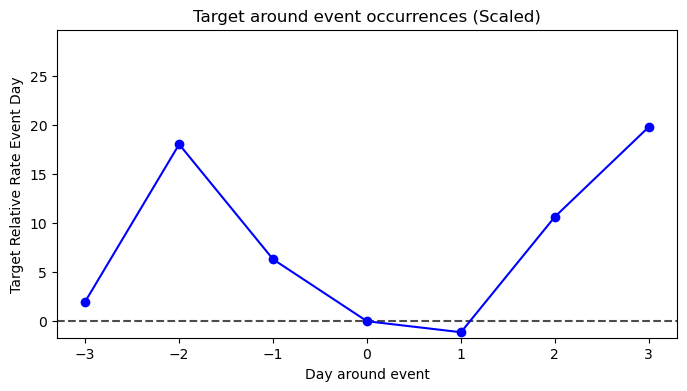

In [136]:
# 계산 편리를 위한 인덱스 초기화 
date_index = test_df.index
test_df.reset_index(drop=True, inplace=True)

# 이벤트 발생 인덱스 찾기
event_indices = test_df.index[test_df['event_flag'] == 1]

# 이벤트 중심 데이터 저장할 리스트
event_window = range(-3, 4)  # -10일 ~ +10일 윈도우
event_data = {day: [] for day in event_window}


# 각 이벤트 발생일을 기준으로 -10일 ~ +10일 데이터 수집
for event_idx in event_indices:
    for day in event_window:
        target_idx = event_idx + day
        if 0 <= target_idx < len(test_df):  # 인덱스 범위 체크
            event_data[day].append(test_df.loc[target_idx, 'target'])

test_df.index = date_index

# 각 날짜의 target 평균 및 표준오차 계산
event_avg = {day: np.mean(event_data[day]) for day in event_window}
event_std = {day: np.std(event_data[day]) / np.sqrt(len(event_data[day])) for day in event_window}

event_transaction_df = pd.DataFrame({'Day': list(event_avg.keys()), 'Mean': list(event_avg.values()), 'SE': list(event_std.values())})

baseline = event_transaction_df[event_transaction_df['Day'] == 0]['Mean'].values[0]  # 0일 기준
se_baseline = event_transaction_df[event_transaction_df['Day'] == 0]['SE'].values[0]  # 0일 기준
event_transaction_df['Relative Change (%)'] = ((event_transaction_df['Mean'] - baseline) / baseline) * 100
event_transaction_df['SE Change (%)'] = ((event_transaction_df['SE']) / se_baseline)

# 그래프 그리기
plt.figure(figsize=(8, 4))
# plt.errorbar(event_transaction_df['Day'], event_transaction_df['Relative Change (%)'],
#              yerr=event_transaction_df['SE Change (%)'], fmt='-o', color='blue', capsize=3)

plt.errorbar(event_transaction_df['Day'], event_transaction_df['Relative Change (%)'],
             yerr=0, fmt='-o', color='blue', capsize=3)

plt.axhline(0, linestyle='dashed', color='black', alpha=0.7)  # 0 축
plt.xlabel("Day around event")
plt.ylabel("Target Relative Rate Event Day")
plt.title("Target around event occurrences (Scaled)")

plt.ylim(event_transaction_df['Relative Change (%)'].min() * 1.5, event_transaction_df['Relative Change (%)'].max() * 1.5)

plt.show()


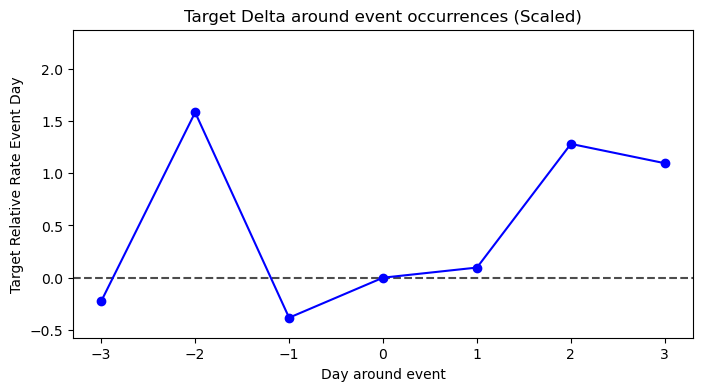

In [137]:
# 계산 편리를 위한 인덱스 초기화 
date_index = test_df.index
test_df.reset_index(drop=True, inplace=True)

# 이벤트 발생 인덱스 찾기
event_indices = test_df.index[test_df['event_flag'] == 1]

# 이벤트 중심 데이터 저장할 리스트
event_window = range(-3, 4)  # -10일 ~ +10일 윈도우
event_data = {day: [] for day in event_window}

test_df['lag_target_delta'] = test_df['target_delta'].shift(0)
# 각 이벤트 발생일을 기준으로 -10일 ~ +10일 데이터 수집
for event_idx in event_indices:
    for day in event_window:
        target_idx = event_idx + day
        if 0 <= target_idx < len(test_df):  # 인덱스 범위 체크
            event_data[day].append(test_df.loc[target_idx, 'lag_target_delta'])

test_df.index = date_index

# 각 날짜의 target 평균 및 표준오차 계산
event_avg = {day: np.mean(event_data[day]) for day in event_window}
event_std = {day: np.std(event_data[day]) / np.sqrt(len(event_data[day])) for day in event_window}

event_transaction_df = pd.DataFrame({'Day': list(event_avg.keys()), 'Mean': list(event_avg.values()), 'SE': list(event_std.values())})

baseline = event_transaction_df[event_transaction_df['Day'] == 0]['Mean'].values[0]  # 0일 기준
se_baseline = event_transaction_df[event_transaction_df['Day'] == 0]['SE'].values[0]  # 0일 기준
event_transaction_df['Relative Change (%)'] = ((event_transaction_df['Mean'] - baseline) / baseline) * 100
event_transaction_df['SE Change (%)'] = ((event_transaction_df['SE']) / se_baseline)

# 그래프 그리기
plt.figure(figsize=(8, 4))

# ### 값으로 보기
# plt.errorbar(event_transaction_df['Day'], event_transaction_df['Mean'],
#              yerr=event_transaction_df['SE'], fmt='-o', color='blue', capsize=3)

# ### 비율로 보기
# plt.errorbar(event_transaction_df['Day'], event_transaction_df['Relative Change (%)'],
#              yerr=event_transaction_df['SE Change (%)'], fmt='-o', color='blue', capsize=3)

### 비율로 보기 Mean 값만
plt.errorbar(event_transaction_df['Day'], event_transaction_df['Relative Change (%)'],
             yerr=0, fmt='-o', color='blue', capsize=3)

plt.axhline(0, linestyle='dashed', color='black', alpha=0.7)  # 0 축
plt.xlabel("Day around event")
plt.ylabel("Target Relative Rate Event Day")
plt.title("Target Delta around event occurrences (Scaled)")

plt.ylim(event_transaction_df['Relative Change (%)'].min() * 1.5, event_transaction_df['Relative Change (%)'].max() * 1.5)

plt.show()


### 백테스팅

C:\Users\slaye\AppData\Local\Temp\ipykernel_28840\290768041.py:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plot_target = plot_target/plot_target[0]
C:\Users\slaye\AppData\Local\Temp\ipykernel_28840\290768041.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plot_price = plot_price/plot_price[0]
C:\Users\slaye\AppData\Local\Temp\ipykernel_28840\290768041.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.plot(plot_targe

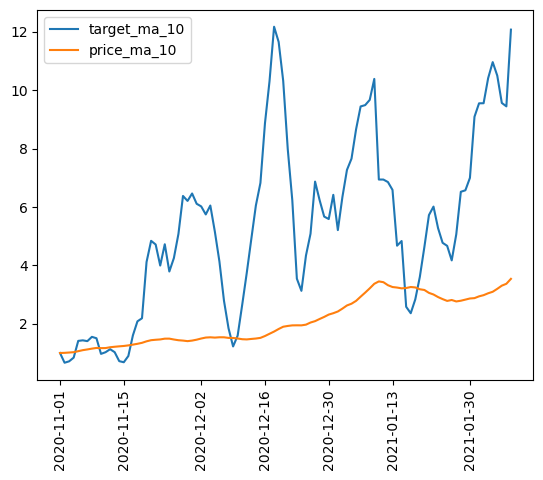

In [138]:
### Target MA, Close MA 시각화
# 시간단위 분할
start = 1400
end = 1500

# Plot 용도 변수
plot_target = test_df.target
plot_target = plot_target/plot_target[0]
plot_price = test_df.close
plot_price = plot_price/plot_price[0]
plot_returns = test_df.returns
plot_target_returns = test_df.target_returns

# Moving Average 계산
plot_target_ma_10 = plot_target.rolling(5).mean().fillna(plot_target.mean())
plot_price_ma_10 = plot_price.rolling(5).mean().fillna(plot_target.mean())


# # 그래프 찍어보기기
# plt.plot(plot_target[start:end]/plot_target[start]/100, label='target')
# plt.plot(plot_price[start:end], label='price')
plt.plot(plot_target_ma_10[start:end]/plot_target_ma_10[start], label='target_ma_10')
plt.plot(plot_price_ma_10[start:end]/plot_price_ma_10[start], label='price_ma_10')
# plt.plot(plot_returns[start:end], label='returns')
# plt.plot(plot_target_returns[start:end]/30, label='target_returns)
plt.xticks(rotation=90)
plt.legend()

# x축 자동으로 적절한 간격 설정
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.AutoDateLocator())  

plt.show()

In [139]:
### test_df에 target_df 데이터 적용
test_df['transaction_count'] = target_df['transaction_count']
test_df['transaction_amount'] = target_df['transaction_amount']
test_df['transaction_flag'] = target_df['transaction_flag']
test_df['transaction_amount_usd'] = test_df['transaction_amount'] * test_df['close']

# trading flag 생성
test_df['transaction_amount_returns'] = test_df['transaction_amount_usd'].pct_change(1).fillna(test_df.mean())
test_df['transaction_amount_trading_flag'] = test_df['transaction_amount_returns'].apply(lambda x: 1 if x > 0 else (-1 if x < -0 else (-1 if x == np.inf else 0)))
test_df['transaction_amount_trading_reversion'] = test_df['transaction_amount_returns'].apply(lambda x: -1 if x > 0 else (1 if x < -0 else 0))

# 지연 수익률 계산, carrying 수익률 
test_df['returns'] = test_df['close'].pct_change(1).fillna(test_df.mean())
test_df['returns_after_1day'] = test_df['returns'].shift(-1).fillna(test_df.mean())
test_df['returns_after_2day'] = test_df['returns'].shift(-2).fillna(test_df.mean())
test_df['returns_after_3day'] = test_df['returns'].shift(-3).fillna(test_df.mean())
test_df['returns_during_2day'] = test_df['close'].pct_change(2).shift(-2).fillna(test_df.mean())
test_df['returns_during_3day'] = test_df['close'].pct_change(3).shift(-3).fillna(test_df.mean())

## 변화율에서 inf값 나올텐데 그거 어떻게 처리할지
test_df = test_df.replace([np.inf, -np.inf], np.nan)
test_df = test_df.fillna(test_df.mean())
test_df

,returns,close,abs_returns,volume,open,high,low,high_low,daily_avg_trades,daily_sum_trades,...,transaction_flag,transaction_amount_usd,transaction_amount_returns,transaction_amount_trading_flag,transaction_amount_trading_reversion,returns_after_1day,returns_after_2day,returns_after_3day,returns_during_2day,returns_during_3day
date,,,,,,,,,,,,,,,,,,,,,
2017-01-01,0.006327,0.015684,0.058470,0.000746,0.015346,0.017147,0.020196,0.018747,0.097865,0.097794,...,1,16333.319428,1.730714,0,0,-0.161223,0.034383,-0.056459,-0.132383,-0.181368
2017-01-02,-0.161223,0.013155,0.104388,0.001279,0.015684,0.015532,0.016372,0.029674,0.097865,0.097794,...,1,11918.929323,-0.270269,-1,1,0.034383,-0.056459,-0.078338,-0.024017,-0.100473
2017-01-03,0.034383,0.013608,0.019476,0.000202,0.013155,0.012882,0.015077,0.022439,0.097865,0.097794,...,1,43393.243776,2.640700,1,-1,-0.056459,-0.078338,0.029021,-0.130374,-0.105136
2017-01-04,-0.056459,0.012840,0.032828,0.000314,0.013608,0.013256,0.017742,0.010913,0.097865,0.097794,...,1,43925.550882,0.012267,1,-1,-0.078338,0.029021,0.086970,-0.051590,0.030894
2017-01-05,-0.078338,0.011834,0.043543,0.000610,0.012840,0.011959,0.015979,0.013080,0.097865,0.097794,...,1,20272.781954,-0.538474,-1,1,0.029021,0.086970,0.218381,0.118516,0.362778
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-09-26,0.033720,0.886977,0.081047,0.037034,0.858044,0.887405,0.873558,0.231546,0.286434,0.286716,...,1,6191.198600,1.730714,1,-1,0.009615,0.001407,-0.004085,0.011035,0.006905
2024-09-27,0.009615,0.895505,0.023147,0.028712,0.886977,0.896753,0.904936,0.121552,0.229749,0.229995,...,0,0.000000,-1.000000,-1,1,0.001407,-0.004085,-0.036441,-0.002684,-0.039027
2024-09-28,0.001407,0.896765,0.003389,0.011710,0.895505,0.893377,0.913727,0.059555,0.088050,0.088204,...,1,18681.147014,1.730714,1,-1,-0.004085,-0.036441,0.006376,-0.040377,0.024105


In [140]:
# check test df 날짜 인덱싱
check_test_df = test_df.copy()
check_test_df = check_test_df[check_test_df.index>='2023-01-01']

# Scaling, Weighted Return 파생변수 생성
check_test_df['scaled_transaction_amount'] = (check_test_df['transaction_amount']-check_test_df['transaction_amount'].min()) / (check_test_df['transaction_amount'].max()-check_test_df['transaction_amount'].min())
check_test_df['transaction_amount_weight_returns'] = check_test_df['scaled_transaction_amount'] * check_test_df['returns']
check_test_df['lag_reversion_returns'] = check_test_df['transaction_amount_trading_reversion'] * check_test_df['returns_after_1day']

# Trading 결과 확인하기 위해 adjusted_returns 생성
trading_price_df = check_test_df[check_test_df['transaction_amount_trading_flag']==-1]
check_test_df['adjusted_returns'] = 0 # 새로운 열 'adjusted_returns'를 생성하여 기본값을 0으로 설정
check_test_df.loc[trading_price_df.index, 'adjusted_returns'] = trading_price_df['returns_after_2day'] # trading_price_df의 index에 해당하는 행만 원래 'returns' 값을 유지

# trading_price_df = check_test_df[check_test_df['transaction_amount_trading_flag']==1]
# trading_price_df['returns_after_2day'] = trading_price_df['returns_after_2day'].apply(lambda x: -x)
# check_test_df.loc[trading_price_df.index, 'adjusted_returns'] = trading_price_df['returns_after_2day'] # trading_price_df의 index에 해당하는 행만 원래 'returns' 값을 유지

C:\Users\slaye\AppData\Local\Temp\ipykernel_28840\624045882.py:13: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[ 1.71316056e-04 -1.35491833e-03 -5.14473939e-04  3.61795591e-03
  1.87572734e-02  6.12271456e-02  6.91925966e-02  6.12215884e-02
  1.77661731e-02 -2.82497334e-03  8.92276669e-02  5.97283423e-03
 -1.43738946e-02  2.20146504e-02 -2.59289097e-03 -4.45743940e-02
  1.52252391e-02 -1.95617003e-02 -8.63001161e-03 -5.89992505e-02
  1.28746914e-02 -5.14667762e-04  2.89884219e-03 -1.67976111e-02
  2.70572041e-02 -1.15280241e-02 -3.63791360e-02 -1.41126320e-03
 -1.72643842e-02 -8.00637966e-03  4.36746870e-03 -1.05190835e-03
 -1.10316956e-02 -1.23174481e-02  1.79840782e-02  2.66162185e-02
  3.38025392e-02  1.09875120e-01 -1.03236584e-02  4.34062908e-02
 -3.34950584e-02  2.08083322e-02 -3.40263521e-02  5.68852882e-03
 -1.27215955e-02 -1.11171320e-02 -1.48850111e-02  1.48498759e-02
 -5.45174551e-03  1.5571

C:\Users\slaye\AppData\Local\Temp\ipykernel_28840\870813761.py:27: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print('cumulative returns: ', (check_test_df.returns+1).cumprod()[-1])


sharpe ratio:  1.558153942985173
cumulative returns:  4.503621554992071
MDD:  -0.2734475245119049


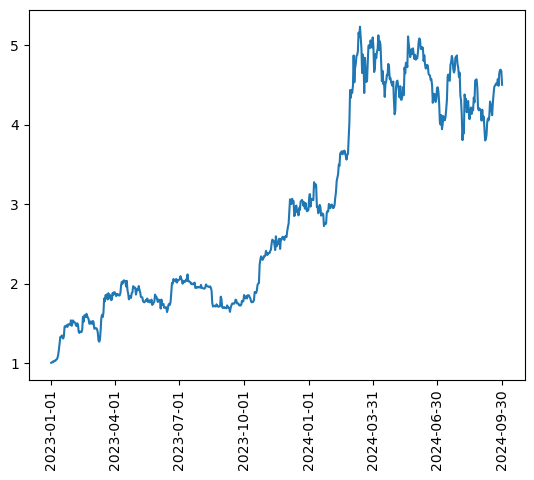

sharpe ratio:  1.749120647711393
cumulative returns:  3.6797096719674416
MDD:  -0.21559655170123573


C:\Users\slaye\AppData\Local\Temp\ipykernel_28840\870813761.py:45: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print('cumulative returns: ', (check_test_df.adjusted_returns+1).cumprod()[-1])


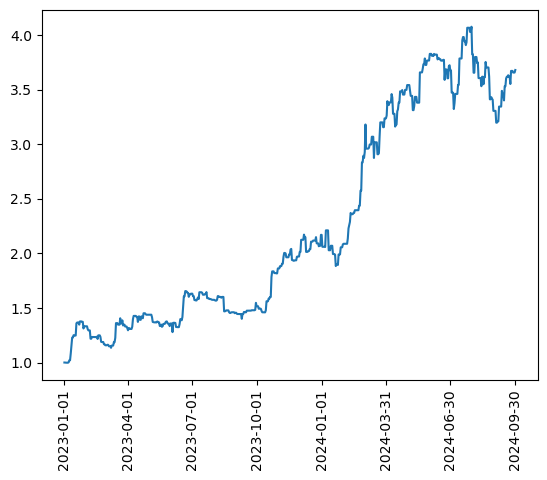

In [141]:
# # 각 전략, 수익률별 그래프 및 지표
# # transaction weighted average returns
# plt.plot((check_test_df.transaction_amount_weight_returns+1).cumprod())
# print('sharpe ratio: ', check_test_df.transaction_amount_weight_returns.mean()/check_test_df.transaction_amount_weight_returns.std()*np.sqrt(252))
# print('cumulative returns: ', (check_test_df.transaction_amount_weight_returns+1).cumprod()[-1])
# print('MDD: ', calculate_mdd((check_test_df.transaction_amount_weight_returns+1).cumprod()))
# plt.xticks(rotation=90)
# ax = plt.gca()
# ax.xaxis.set_major_locator(mdates.AutoDateLocator())
# plt.show()


# # lag_reversion_returns
# plt.plot((check_test_df.lag_reversion_returns+1).cumprod())
# print('sharpe ratio: ', check_test_df.lag_reversion_returns.mean()/check_test_df.lag_reversion_returns.std()*np.sqrt(252))
# print('cumulative returns: ', (check_test_df.lag_reversion_returns+1).cumprod()[-1])
# print('MDD: ', calculate_mdd((check_test_df.lag_reversion_returns+1).cumprod()))
# plt.xticks(rotation=90)
# ax = plt.gca()
# ax.xaxis.set_major_locator(mdates.AutoDateLocator())
# plt.show()


# trading 없이 비교
plt.plot((check_test_df.returns+1).cumprod())
print('sharpe ratio: ', check_test_df.returns.mean()/check_test_df.returns.std()*np.sqrt(252))
print('cumulative returns: ', (check_test_df.returns+1).cumprod()[-1])
print('MDD: ', calculate_mdd((check_test_df.returns+1).cumprod()))
plt.xticks(rotation=90)
ax = plt.gca()  # 현재 그래프의 X축 가져오기
ax.xaxis.set_major_locator(mdates.AutoDateLocator())  # 자동으로 적절한 간격 설정
plt.show()

# # 1일 뒤 returns (1 day carrying)
# plt.plot((trading_price_df['returns_after_1day']+1).cumprod())
# print('sharpe ratio: ', trading_price_df['returns_after_1day'].mean()/trading_price_df['returns_after_1day'].std()*np.sqrt(252))
# # trading 없이 비교
# plt.plot((check_test_df['returns']+1).cumprod())
# print('sharpe ratio: ', check_test_df['returns'].mean()/check_test_df['returns'].std()*np.sqrt(252))
# plt.show()

# 2일 뒤 returns (2 day after returns)
plt.plot((check_test_df.adjusted_returns+1).cumprod())
print('sharpe ratio: ', check_test_df.adjusted_returns.mean()/check_test_df.adjusted_returns.std()*np.sqrt(252))
print('cumulative returns: ', (check_test_df.adjusted_returns+1).cumprod()[-1])
print('MDD: ', calculate_mdd((check_test_df.adjusted_returns+1).cumprod()))
plt.xticks(rotation=90)
ax = plt.gca()  # 현재 그래프의 X축 가져오기
ax.xaxis.set_major_locator(mdates.AutoDateLocator())  # 자동으로 적절한 간격 설정
plt.show()

# # 2일 뒤 returns (2 day after returns)
# plt.plot((trading_price_df['returns_after_2day']+1).cumprod())
# print('sharpe ratio: ', trading_price_df['returns_after_2day'].mean()/trading_price_df['returns_after_2day'].std()*np.sqrt(252))

# # 2일 동안 returns (2 day carrying)
# plt.plot((trading_price_df['returns_during_2day']+1).cumprod())
# print('sharpe ratio: ', trading_price_df['returns_during_2day'].mean()/trading_price_df['returns_during_2day'].std()*np.sqrt(252))

### 정의한 Informed Trading으로 어떤 것을 예측하기 좋은지
### XGBoost를 이용할 계획...